# CoNLL 2003 NER with Bi-LSTM-CRF

In [92]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="";  

In [93]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
%matplotlib inline

In [95]:
import pandas as pd
import numpy as np

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

In [97]:
from conlleval import evaluate

In [98]:
from ner_utils import *

## Get  data

In [99]:
def IOB2BIO(input_file, output_file):
    print("Convert IOB -> BIO for file:", input_file)
    with open(input_file,'r') as in_file:
        fins = in_file.readlines()
    fout = open(output_file,'w')
    words = []
    labels = []
    for line in fins:
        if len(line) < 3:
            sent_len = len(words)
            for idx in range(sent_len):
                if "I-" in labels[idx]:
                    label_type = labels[idx].split('-')[-1]
                    if (idx == 0) or (labels[idx-1] == "O") or (label_type != labels[idx-1].split('-')[-1]):
                        fout.write(words[idx]+" B-"+label_type+"\n")
                    else:
                        fout.write(words[idx]+" "+labels[idx]+"\n")
                else:
                    fout.write(words[idx]+" "+labels[idx]+"\n")
            fout.write('\n')
            words = []
            labels = []
        else:
            pair = line.strip('\n').split()
            words.append(pair[0])
            labels.append(pair[-1].upper())
    fout.close()
    print("BIO file generated:", output_file)
    
    
def BIO2BIOES(input_file, output_file):
    print("Convert BIO -> BIOES for file:", input_file)
    with open(input_file,'r') as in_file:
        fins = in_file.readlines()
    fout = open(output_file,'w')
    words = []
    labels = []
    for line in fins:
        if len(line) < 3:
            sent_len = len(words)
            for idx in range(sent_len):
                if "-" not in labels[idx]:
                    fout.write(words[idx]+" "+labels[idx]+"\n")
                else:
                    label_type = labels[idx].split('-')[-1]
                    if "B-" in labels[idx]:
                        if (idx == sent_len - 1) or ("I-" not in labels[idx+1]):
                            fout.write(words[idx]+" S-"+label_type+"\n")
                        else:
                            fout.write(words[idx]+" B-"+label_type+"\n")
                    elif "I-" in labels[idx]:
                        if (idx == sent_len - 1) or ("I-" not in labels[idx+1]):
                            fout.write(words[idx]+" E-"+label_type+"\n")
                        else:
                            fout.write(words[idx]+" I-"+label_type+"\n")
            fout.write('\n')
            words = []
            labels = []
        else:
            pair = line.strip('\n').split()
            words.append(pair[0])
            labels.append(pair[-1].upper())
    fout.close()
    print("BIOES file generated:", output_file)

In [114]:
def get_case_feature(token):
    if token.isdigit():
        return 'digit'
    
    if token.isalpha():
        al = 'alpha_'
    elif token.isalnum():
        al = 'alnum_'
    else:
        al = 'misc_'
    
    if token.isupper():
        return al+'upper'
    if token.islower():
        return al+'lower'
    if token.istitle():
        return al+'title'
    else:
        return al+'other'
    
    return 'unk'
        

In [115]:
from io import StringIO

def read_conll2003(path):
    dfs = []
    for i, sent in enumerate(open(path, 'r', encoding='utf8').read().split('\n\n')):
        dfs.append(pd.read_csv(StringIO(sent), sep=' ', header=None, quoting=3, 
                               names = ['token_str', 'ner'])
                  .assign(sent_id = i+1))
    
    return pd.concat(dfs).reset_index(drop=True).astype(str).assign(cap = lambda x: x.token_str.apply(get_case_feature))

In [116]:
train = read_conll2003('data/eng.train.bioes').assign(sent_id=lambda x: x.sent_id.astype(int))
testa = read_conll2003('data/eng.testa.bioes').assign(sent_id=lambda x: x.sent_id.astype(int)+train.sent_id.max())
testb = read_conll2003('data/eng.testb.bioes').assign(sent_id=lambda x: x.sent_id.astype(int)+testa.sent_id.max())

In [117]:
train.sent_id.nunique(), testa.sent_id.nunique(), testb.sent_id.nunique()

(14987, 3466, 3684)

In [118]:
train.head()

,token_str,ner,sent_id,cap
0,-DOCSTART-,O,1,misc_upper
1,EU,S-ORG,2,alpha_upper
2,rejects,O,2,alpha_lower
3,German,S-MISC,2,alpha_title
4,call,O,2,alpha_lower


In [119]:
train.sent_id.nunique(), testa.sent_id.nunique(), testb.sent_id.nunique()

(14987, 3466, 3684)

In [120]:
#train = pd.concat([train, testb])

In [121]:
train.sent_id.nunique()

14987

In [132]:
train_sents = train.groupby('sent_id')[['token_str', 'ner', 'cap']].apply(lambda x: x.values.tolist())
testa_sents = testa.groupby('sent_id')[['token_str', 'ner', 'cap']].apply(lambda x: x.values.tolist())
testb_sents = testb.groupby('sent_id')[['token_str', 'ner', 'cap']].apply(lambda x: x.values.tolist())
train_sents.head()

sent_id
1                        [[-DOCSTART-, O, misc_upper]]
2    [[EU, S-ORG, alpha_upper], [rejects, O, alpha_...
3    [[Peter, B-PER, alpha_title], [Blackburn, E-PE...
4    [[BRUSSELS, S-LOC, alpha_upper], [1996-08-22, ...
5    [[The, O, alpha_title], [European, B-ORG, alph...
dtype: object

In [133]:
words = list(set(train.token_str.values)|set(testa.token_str.values)|set(testb.token_str.values))
n_words = len(words); n_words

30292

In [134]:
tags = list(set(train.ner.values))
n_tags = len(tags); n_tags

17

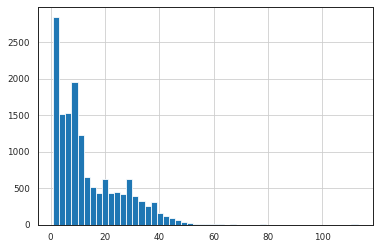

In [135]:
train.groupby('sent_id').size().hist(bins=50)

In [136]:
max_len = 60
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [137]:
from keras.preprocessing.sequence import pad_sequences
X_train = [[word2idx[w[0]] for w in s] for s in train_sents]
X_testa   = [[word2idx[w[0]] for w in s] for s in testa_sents]
X_testb  = [[word2idx[w[0]] for w in s] for s in testb_sents]


In [138]:
X_train = pad_sequences(maxlen=max_len, sequences=X_train, value=word2idx["PAD"], padding='post', truncating='post')
X_testa = pad_sequences(maxlen=max_len, sequences=X_testa, value=word2idx["PAD"], padding='post', truncating='post')
X_testb = pad_sequences(maxlen=max_len, sequences=X_testb, value=word2idx["PAD"], padding='post', truncating='post')
X_train[0]

array([21824,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0], dtype=int32)

In [139]:
pos = list(set(train.cap.values)|set(testa.cap.values)|set(testb.cap.values))
n_pos = len(pos); n_pos

12

In [140]:
pos2idx = {w: i+1 for i, w in enumerate(pos)}
pos2idx["PAD"] = 0

In [141]:
from keras.preprocessing.sequence import pad_sequences
X_pos_train = [[pos2idx[w[2]] for w in s] for s in train_sents]
X_pos_testa   = [[pos2idx[w[2]] for w in s] for s in testa_sents]
X_pos_testb  = [[pos2idx[w[2]] for w in s] for s in testb_sents]

In [142]:
X_pos_train = pad_sequences(maxlen=max_len, sequences=X_pos_train, value=pos2idx["PAD"], padding='post', truncating='post')
X_pos_testa = pad_sequences(maxlen=max_len, sequences=X_pos_testa, value=pos2idx["PAD"], padding='post', truncating='post')
X_pos_testb = pad_sequences(maxlen=max_len, sequences=X_pos_testb, value=pos2idx["PAD"], padding='post', truncating='post')
X_pos_train[0]

array([9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [143]:
from keras.preprocessing.sequence import pad_sequences
y_train = [[tag2idx[w[1]] for w in s] for s in train_sents]
y_testa = [[tag2idx[w[1]] for w in s] for s in testa_sents]
y_testb = [[tag2idx[w[1]] for w in s] for s in testb_sents]

In [144]:
y_numer_train = pad_sequences(maxlen=max_len, sequences=y_train, value=tag2idx["PAD"], padding='post', truncating='post')
y_numer_testa = pad_sequences(maxlen=max_len, sequences=y_testa, value=tag2idx["PAD"], padding='post', truncating='post')
y_numer_testb = pad_sequences(maxlen=max_len, sequences=y_testb, value=tag2idx["PAD"], padding='post', truncating='post')
y_numer_train[0]

array([3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [145]:
from keras.utils import to_categorical
y_train = [to_categorical(i, num_classes=n_tags+1) for i in y_numer_train]
y_testa = [to_categorical(i, num_classes=n_tags+1) for i in y_numer_testa]
y_testb = [to_categorical(i, num_classes=n_tags+1) for i in y_numer_testb]

y_train[0].shape

(60, 18)

In [146]:
#validation_split = len(X_testa) / (len(X_train)+len(X_testa))
validation_split = 0.05
validation_split

0.05

In [147]:
splits = [[X_train, X_testa,
           y_train, y_testa,
           X_pos_train, X_pos_testa]]

### Prep char input

In [148]:
train.token_str.dtype

dtype('O')

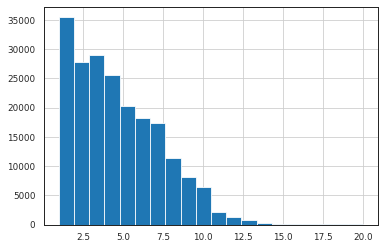

In [149]:
train.token_str.apply(lambda x: 20 if len(x)>20 else len(x)).hist(bins=20)

In [152]:
max_len_char = 15

In [153]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

85


In [154]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [155]:

def get_X_char(sents):
    X_char = []
    for sentence in sents:
        sent_seq = []
        for i in range(max_len):
            word_seq = []
            for j in range(max_len_char):
                try:
                    word_seq.append(char2idx.get(sentence[i][0][j]))
                except:
                    word_seq.append(char2idx.get("PAD"))
            sent_seq.append(word_seq)
        X_char.append(np.array(sent_seq))
    return X_char

In [156]:
X_char_train = get_X_char(train_sents  )
X_char_testa = get_X_char(testa_sents)
X_char_testb = get_X_char(testb_sents )

splits_char = [[X_char_train, X_char_testa,
                y_train, y_testa]]

## Embeddings

In [77]:
#!mkdir data/english_embeddings
#!wget -P data/english_embeddings https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.vec
    

In [157]:
english_emb_paths = { 'en_pretrained_wiki': 'data/english_embeddings/wiki.en.vec'}

In [158]:
exclude = ['cbow', 'word2vec', 'tokenized', 'glove']

In [168]:
embedding_mats = {}
for emb_name, emb_path in english_emb_paths.items():
    skip=False
    for exc in exclude:
        if exc in emb_path:
            skip=True
    if skip:
        continue
    embedding_mats[emb_name] = get_embedding_matrix(emb_path, word2idx, lower_case=True)

loading word embeddings: data/english_embeddings/wiki.en.vec
found 2512763 word vectors
preparing embedding matrix...
number of null word embeddings: 7674
sample words not found:  ['160.36' '.432' 'Interrosimpex' '6-3' '8' '58' '242.94' '38.0' '1:49.28'
 '168']


## Model building

In [169]:
from ner_utils import *
base_configs_stack_freeze

[{'optimizer': 'adam',
  'output_dropout': True,
  'add_random_embedding': False,
  'use_char': True,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'all',
  'trainable': False,
  'stack_lstm': 2},
 {'optimizer': 'adam',
  'output_dropout': True,
  'add_random_embedding': False,
  'use_char': True,
  'crf': True,
  'use_pos': True,
  'embedding_matrix': 'all',
  'trainable': False,
  'stack_lstm': 2}]

In [170]:
configs = build_configs(base_configs_stack_freeze, embedding_mats)
configs     

[{'optimizer': 'adam',
  'output_dropout': True,
  'add_random_embedding': False,
  'use_char': True,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'en_pretrained_wiki',
  'trainable': False,
  'stack_lstm': 2},
 {'optimizer': 'adam',
  'output_dropout': True,
  'add_random_embedding': False,
  'use_char': True,
  'crf': True,
  'use_pos': True,
  'embedding_matrix': 'en_pretrained_wiki',
  'trainable': False,
  'stack_lstm': 2}]

In [176]:
for conf in configs:
    conf['patience'] = 10

In [177]:
out_folder = 'results/english_conll2003'
if not os.path.exists(out_folder):
    os.mkdir(out_folder)

In [178]:
extra_preds = [(X_testb, X_pos_testb, X_char_testb), ]

In [179]:
from ner_utils import *

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 60, 15)       0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 60)           0                                            
__________________________________________________________________________________________________
time_distributed_16 (TimeDistri (None, 60, 15, 20)   1740        input_12[0][0]                   
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 60, 300)      9088200     input_11[0][0]                   
__________________________________________________________________________________________________
time_distr

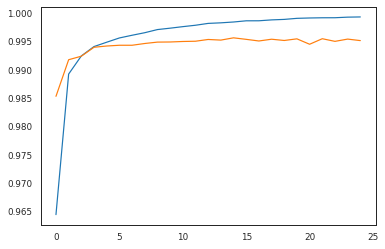

processed 51361 tokens with 5907 phrases; found: 5908 phrases; correct: 5407.
accuracy:  90.68%; (non-O)
accuracy:  98.26%; precision:  91.52%; recall:  91.54%; FB1:  91.53
              LOC: precision:  94.04%; recall:  94.56%; FB1:  94.30  1847
             MISC: precision:  89.74%; recall:  82.72%; FB1:  86.09  848
              ORG: precision:  84.96%; recall:  87.17%; FB1:  86.05  1376
              PER: precision:  94.72%; recall:  96.19%; FB1:  95.45  1837
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 60, 15)       0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           (None, 60)           0                                            
_____________________________________

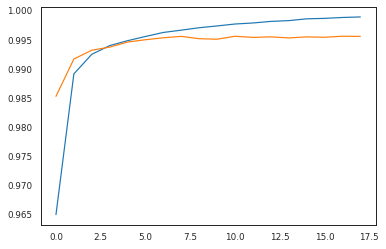

processed 51361 tokens with 5907 phrases; found: 5867 phrases; correct: 5390.
accuracy:  90.56%; (non-O)
accuracy:  98.26%; precision:  91.87%; recall:  91.25%; FB1:  91.56
              LOC: precision:  92.22%; recall:  95.54%; FB1:  93.85  1903
             MISC: precision:  87.46%; recall:  85.65%; FB1:  86.55  901
              ORG: precision:  91.23%; recall:  83.74%; FB1:  87.33  1231
              PER: precision:  94.10%; recall:  95.30%; FB1:  94.70  1832


In [180]:
configs, results, preds, histories = run_models(configs, splits, splits_char, embedding_mats, 
                                                words, max_len, n_words, idx2word, idx2tag,
                                                n_tags, max_len_char, n_pos, n_chars,
                                                run_name='english_conll2003_lower', out_folder=out_folder,
                                                skip_if_model_exists=True,
                                                validation_split=validation_split,
                                                extra_predictions=extra_preds,
                                                )

In [182]:
trunc_testb = []
for s in testb_sents:
    for t, b, c in s[:60]:
        trunc_testb.append(b)

In [183]:
 
with open('results/english_conll2003/english_conll2003-0-extra_preds-0.pkl', 'rb') as f:
    p = pickle.load(f)
    

In [184]:
len(trunc_testb), len(p[0][0])

(46523, 46292)

In [61]:
from conlleval import evaluate

evaluate(replace_pad_with_o(p[0][0]), trunc_testb)

processed 46292 tokens with 5740 phrases; found: 5617 phrases; correct: 4136.
accuracy:  72.57%; (non-O)
accuracy:  94.19%; precision:  73.63%; recall:  72.06%; FB1:  72.84
              LOC: precision:  73.25%; recall:  76.48%; FB1:  74.83  1660
             MISC: precision:  58.83%; recall:  46.20%; FB1:  51.75  702
              ORG: precision:  68.55%; recall:  75.77%; FB1:  71.98  1660
              PER: precision:  85.83%; recall:  78.05%; FB1:  81.76  1595


(73.63361224853125, 72.05574912891987, 72.83613630360131)

In [186]:
 with open('results/english_conll2003/english_conll2003_lower-0-extra_preds-0.pkl', 'rb') as f:
    p = pickle.load(f)
evaluate(replace_pad_with_o(p[0][0]), trunc_testb)

processed 46523 tokens with 5658 phrases; found: 5617 phrases; correct: 4996.
accuracy:  88.76%; (non-O)
accuracy:  97.51%; precision:  88.94%; recall:  88.30%; FB1:  88.62
              LOC: precision:  91.87%; recall:  89.92%; FB1:  90.88  1660
             MISC: precision:  78.06%; recall:  80.12%; FB1:  79.08  702
              ORG: precision:  85.36%; recall:  84.60%; FB1:  84.98  1660
              PER: precision:  94.42%; recall:  93.95%; FB1:  94.18  1595


(88.94427630407691, 88.29975256274302, 88.62084257206209)

In [187]:
 with open('results/english_conll2003/english_conll2003_lower-1-extra_preds-0.pkl', 'rb') as f:
    p = pickle.load(f)
evaluate(replace_pad_with_o(p[0][0]), trunc_testb)

processed 46523 tokens with 5607 phrases; found: 5617 phrases; correct: 4954.
accuracy:  88.60%; (non-O)
accuracy:  97.47%; precision:  88.20%; recall:  88.35%; FB1:  88.28
              LOC: precision:  93.01%; recall:  88.68%; FB1:  90.80  1660
             MISC: precision:  77.49%; recall:  77.94%; FB1:  77.71  702
              ORG: precision:  82.53%; recall:  86.33%; FB1:  84.39  1660
              PER: precision:  93.79%; recall:  94.62%; FB1:  94.21  1595


(88.19654619903862, 88.35384341002317, 88.27512473271561)